## Tasks with Sequential Data 
consider a task to fit the data $t = 1, 2, 3, \dots,$ and $x_t = x(t) = \sin(0.1 t)$ (you do not know it in advance), given samples of $t$ from $1$ to $n$, the task is to predict the value of $x(t)$, when $t = n+1$.

- Method 1: find the function $x(t)$ directly
    - asumme $x(t)$ is a polynomial and fit it by Least Square Method.
    - since Neural Network can approximate any functions in theory, fit the data by a fully connected neural network / feed forward network.
- Method 2: find the recurrence relations of $x_t$
    - Actually $x_t \approx 1.99 x_{t-1} - x_{t-2}$ 
    - The model only need 2 parameters, however, yields very good results! 

- Feed forward networks are not so efficent to deal with tasks with sequential data. 
    - do not make use of the sequential relationship explicitly.
    - large number of parameters.
    - fixed size vector input and output, but the tasks may require flexible size.


![task.png](img/task.png)


- tasks
    - one to one example 
        - e.g slot filling: classify the words, 0: irrelevant, 1: destination, 2:departure, 3 time.
            - I will go to SZ this Sat. ->[ 0, 0, 0, 0, 1, 0, 3] 
            - I will leave HK this Sat. ->[ 0, 0, 0, 0, 2, 0, 3] 
        - predict the type of word in a sentence: -> verb, noun
    - one to many
        - image caption 
    - many to one
        - Sentiment Analysis 
            - "The paper, Learning to l Gradient by Gradient Decent, is very very hard to understand."-> negative 
            - "LSTM is not something difficult to learn."-> positive

    - many to many
        - translation
        
We will focus on the basic one to one cases.

## Traditional method

- Time series prediction task

![timeS.png](img\timeS.png)
- Traditional method e.g  The Autoregressive–moving-average model

$$X_t = c + \varepsilon_t + \sum_i^p \phi_i X_{t-i} + \sum_i^q \theta_i \varepsilon_{t-i} $$

- Assume that $X_t$ is subject to the model ARMA(p, q) first, then evaluate the parameters by fitting the data. 

    - limited by the linear form of the model if the true recurrence relations are nonlinear
        - $X_t = f(X_{t-1}, X_{t-2}, \dots )$

## recurrent networks
- DNNs, one layer forward: $x_i \rightarrow$  after apply affine transfomation: $ W x_i + b \rightarrow$ then the nonlinearity $h_i = \sigma( W x_i +b ) \rightarrow$ the next layer 
- RNNs, one layer forward: $x_t \rightarrow$  when applying affine transfomation, also use the information of previous hidden state: $ U x_t + V h_{t-1} + b \rightarrow$ then the nonlinearity $h_i = \sigma( U x_t + V h_{t-1} + b) \rightarrow$ the next layer
![RNN.svg](img\RNN.svg) 
- Viewpoint: RNN can be viewed as networks with "short-term memory".
    - DNN, given a $x_i$, get output $f(x_i)$
    - RNN, given a $x_t$, get output $f(x_t, h_{t-1})$, then the memory $h_{t-1}$ is combined with some information for $x_t$ and updated to $h_t$.

- a simple generated example:
    - use one layer RNN with 1-d input, 1-d output and no acitivations, no affine transform for the output, to predict the seqence generated by ARMA(1, 0): $X_t = -0.05 + 0.99 X_{t-1} + \varepsilon_t$
        - Input: $X_t$, initialized by $X_0 = h_0 = 0$
        - Output: $h_t = W_x X_t + W_h h_{t-1} +b = f( \phi;x_t, h_{t-1},)$, where $\phi =\{W_x, W_h, b\}$ including all the parameters of the network for short.
        - Loss: use $l_2$ loss, $(h_t-X_{t+1})^2$, the total lost is the sum over all the time step, $t= 1, 2, \dots,T$.
     

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
def getSample(n, x0 = None, ar = np.array([]), ma = np.array([]), c = 0, sig= 1):
    p, q = len(ar), len(ma)
    if x0 is None: x0 = np.zeros(p)
    e = sig * np.random.randn(n+q)
    x = np.empty(n + p)
    x[:p] = x0[-p:]
    for i in range(n):
        x[p+i] = c + e[i+q] + x[i:i+p].dot(ar) + e[i:i+q].dot(ma)
    return x[p:]


loss: 13.382750305320815
loss: 0.0008614868967846247
loss: 0.0008351518482966048
Wx: [[0.92492892]] Wh: [[0.06602186]] b: [-0.04758399]
Wx+Wh= [[0.99095079]]


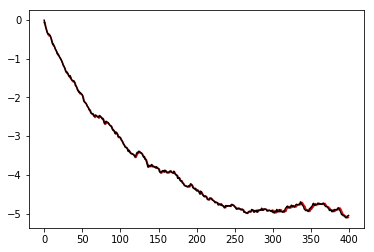

In [10]:
x = getSample(500, ar = np.array([0.99]),sig=0.03, c= -0.05)

import network as nw
from loss import Lossl2
from optimizer import Gradientdescent
N_train, N_test = 300, 100

x_train, x_test = x[:N_train], x[N_train:N_train+N_test]
y_train, y_test = x[1:N_train+1], x[1+N_train: 1+N_train+N_test]

layers = [nw.RnnLayer(1,1, activation = None)]     

net = nw.NeuralNetwork(layers, Lossl2, optimizer = Gradientdescent(alpha = 0.03, decay_rate = 0.99, decay_step = 200))
net.train(x_train, y_train, max_iter = 900, print_every = 300 , batch_size = None)

layers[0].print()
print("Wx+Wh=", layers[0].Wx + layers[0].Wh)

x_pre = np.zeros(N_train+N_test)

x_pre[:N_train] = net.predict((x[:N_train]).reshape(-1)).reshape(-1)
for i in range(N_test):
    x_pre[i+N_train] = net.predict(x[i+N_train - 1]).reshape(-1)

plt.plot(x_pre, c='red')
plt.plot(x[1:1+N_train+N_test], c='black')
plt.show()


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanilla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$


![image.png](img\LSTM.png)
Image by François Deloche, via Wikimedia Commons




## learn2learn 
- Observation 
    - the updation of the iterative optimization method can be viewed as timeseries
    - widely used first order methods, e.g. SGD, NAG, RMSprop, ADAM, act to each entries of parameters elementwise.
    - e.g ![RMSprop.png](img/RMSprop.png)
- Just fill in the blank 
    - For every intries $\theta_j$ in the parameters $\theta$ of the Optimizee $f(\theta)$ 
        - Input: a real number $(\nabla_t)_j = (\nabla_{\theta} \, f(\theta_t))_j$ 
        - Output: a real number $g_j$, the returned value of the network $\mathrm{LSTM\_Network}(\phi; (\nabla_t)_j, h_j)$
    - Loss:
        - first update the $\theta_t$ to $\theta_{t+1}$ by, for every $j$, do $\theta_j \leftarrow \theta_j + g_j$ 
        - the loss after one time step is just the value of the Optimizee $f(\theta_{t+1})$ 
        - the total loss is the sum of loss over all the $T$ time step

http://nbviewer.jupyter.org/github/AdrienLE/learning_by_grad_by_grad_repro/blob/master/Grad%5E2.ipynb